# Overwriting feature layers

As content publishers, you may be required to keep certain web layers up to date. As new data arrives, you may have to append new features, update existing features etc. There are a couple of different options to accomplish this:
 
 - Method 1: editing individual features as updated datasets are available
 - Method 2: overwriting feature layers altogether with updated datasets
 
Depending on the number of features that are updated, your workflow requirements, you may adopt either or both kinds of update mechanisms.

In the sample [Updating features in a feature layer](python/sample-notebooks/updating-features-in-a-feature-layer/) we explore method 1. In this sample, we explore method 2.

**Method 2**
 - [Introduction](#Introduction)
 - [Publish the cities feature layer using the initial dataset](Publish-the-cities-feature-layer-using-the-initial-dataset)
 - [Merge updates from spreadsheets 1 and 2](#Merge-updates-from-spreadsheets-1-and-2)
   - [Write the updates to disk](#Write-the-updates-to-disk)
 - [Overwrite the feature layer](#Overwrite-the-feature-layer)
   - [Access the overwritten feature layer](#Access-the-overwritten-feature-layer)
 - [Conclusion](#Conclusion)

In [1]:
# Import libraries
from arcgis.gis import GIS
from arcgis import features
from getpass import getpass #to accept passwords in an interactive fashion
import pandas as pd

In [2]:
# Connect to the GIS
password = getpass()
gis = GIS("https://geosaurus.maps.arcgis.com",'arcgis_python', password)

········


## Introduction

Let us consider a scenario where we need to update a feature layer containing the capital cities of the US. We have 2 csv datasets simulating an update workflow as described below:

 1. usa_capitals_1.csv -- contains the initial, incomplete dataset which is published as a feature layer
 2. usa_capitals_2.csv -- contains additional points and updates to existing points, building on top of usa_capitals_1.csv
 
Our goal is to update the features in the feature layer with the latest information contained in both the spreadsheets. We will accomplish this through the following steps

 1. Add `usa_capitals_1.csv` as an item.
 2. Publish the csv as a feature layer. This simulates a typical scenario where a feature layer is published with initial set of data that is available.
 3. After updated information is available in `usa_capitals_2.csv`, we will merge both spread sheets.
 4. Overwrite the feature layer using the new spread sheet file.
 
When you overwrite a feature layer, only the features get updated. All other information such as the feature layer's item id, comments, summary, description etc. remain the same. This way, any web maps or scenes that have this layer remains valid. Overwriting a feature layer also updates the related data item from which it was published. In this case, it will also update the csv data item with the updated spreadsheet file.

**Note**: Overwrite capability was introduced in ArcGIS Enterprise 10.5 and in ArcGIS Online. This capability is currently only available for feature layers. Further, ArcGIS sets some limits when overwriting feature layers:

 1. The name of the file that used to update in step 4 above should match the original file name of the item.
 2. The schema -- number of layers (applicable when your original file is a file geodatabase / shape file / service definition), and the name and number of attribute columns should remain the same as before.
 
The **method 2** explained in this sample is much simpler compared to **method 1** explained in [Updating features in a feature layer](/python/sample-notebooks/updating-features-in-a-feature-layer/). However, we cannot make use of the third spreadsheet which has the additional columns for our capitals. To do that, we would first update the features through overwriting, then edit the definition of the feature layer to add new columns and then edit each feature and add the appropriate column values, similar to that explained in method 1.

## Publish the cities feature layer using the initial dataset

In [3]:
# read the initial csv
csv1 = 'data/updating_gis_content/usa_capitals_1.csv'
cities_df_1 = pd.read_csv(csv1)
cities_df_1.head()

,city_id,name,state,capital,pop2000,pop2007,longitude,latitude
0,1,Honolulu,HI,State,371657,378587,-157.823436,21.305782
1,2,Juneau,AK,State,30711,31592,-134.511582,58.351418
2,3,Boise City,ID,State,185787,203529,-116.237655,43.613736
3,4,Olympia,WA,State,27514,45523,-122.893073,47.042418
4,5,Salem,OR,State,136924,152039,-123.029155,44.931109


In [4]:
# print the number of records in this csv
cities_df_1.shape

(19, 8)

In [5]:
# add the csv as an item
item_prop = {'title':'USA Capitals spreadsheet 2'}
csv_item = gis.content.add(item_properties=item_prop, data=csv1)
csv_item

<Item title:"USA Capitals spreadsheet 2" type:CSV owner:arcgis_python>

In [6]:
# publish the csv item into a feature layer
cities_item = csv_item.publish()
cities_item

<Item title:"USA Capitals spreadsheet 2" type:Feature Service owner:arcgis_python>

<Item title:"USA Capitals 2" type:Feature Service owner:arcgis_python>
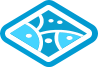

In [7]:
# update the item metadata
item_prop = {'title':'USA Capitals 2'}
cities_item.update(item_properties = item_prop, 
                   thumbnail='data/updating_gis_content/capital_cities.png')
cities_item

In [8]:
map1 = gis.map('USA')
map1

![original web layer](http://esri.github.io/arcgis-python-api/notebooks/nbimages/05_overwriting_feature_layers_01.PNG)

In [9]:
map1.add_layer(cities_item)

In [10]:
cities_item.url

'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/USA_Capitals_spreadsheet_2/FeatureServer'

## Merge updates from spreadsheet 2 with 1
The next set of updates have arrived and are stored in `usa_capitals_2.csv`. We are told it contains corrections for the original set of features and also has new features.

Instead of applying the updates one at a time, we will merge both the spreadsheets into a new one.

In [11]:
# read the second csv set
csv2 = 'data/updating_gis_content/usa_capitals_2.csv'
cities_df_2 = pd.read_csv(csv2)
cities_df_2.head(5)

,city_id,name,state,capital,pop2000,pop2007,longitude,latitude
0,20,Baton Rouge,LA,State,227818,228810,-91.140227,30.458091
1,21,Helena,MT,State,25780,26007,-112.027027,46.595809
2,22,Bismarck,ND,State,55532,59344,-100.779000,46.813346
3,23,Pierre,SD,State,13876,14169,-100.336382,44.367964
4,24,St. Paul,MN,State,287151,291643,-93.114118,44.954364


In [12]:
# get the dimensions of this csv
cities_df_2.shape

(36, 8)

Let us `append` the spreadsheets 1 and 2 and store it in a DataFrame called `updated_df`. Note, this step introduces duplicate rows that were updated in spreadsheet 2.

In [13]:
updated_df = cities_df_1.append(cities_df_2)
updated_df.shape

(55, 8)

Next, we must drop the duplicate rows. Note, in this sample, the `city_id` column has unique values and is present in all spreadsheets. Thus, we are able to determine duplicate rows using this column and drop them.

In [14]:
updated_df.drop_duplicates(subset='city_id', keep='last', inplace=True)
# we specify argument keep = 'last' to retain edits from second spreadsheet
updated_df.shape

(51, 8)

Thus we have dropped 4 rows from spreadsheet 1 and retained the same 4 rows with updated values from spreadsheet 2. Let us see how the DataFrame looks so far:

In [15]:
updated_df.head(5)

,city_id,name,state,capital,pop2000,pop2007,longitude,latitude
0,1,Honolulu,HI,State,371657,378587,-157.823436,21.305782
1,2,Juneau,AK,State,30711,31592,-134.511582,58.351418
2,3,Boise City,ID,State,185787,203529,-116.237655,43.613736
4,5,Salem,OR,State,136924,152039,-123.029155,44.931109
5,6,Carson,NV,State,52457,56641,-119.753873,39.160946


### Write the updates to disk
Let us create a new folder called `updated_capitals_csv` and write the updated features to a csv with the same name as our first csv file.

In [16]:
import os
if not os.path.exists('data/updating_gis_content/updated_capitals_csv'):
    os.mkdir('data/updating_gis_content/updated_capitals_csv')

In [18]:
updated_df.to_csv('data/updating_gis_content/updated_capitals_csv/usa_capitals_1.csv')

## Overwrite the feature layer
Let us overwrite the feature layer using the new csv file we just created. To overwrite, we will use the `overwrite()` method.

In [19]:
from arcgis.features import FeatureLayerCollection
cities_flayer_collection = FeatureLayerCollection.fromitem(cities_item)

In [20]:
#call the overwrite() method which can be accessed using the manager property
cities_flayer_collection.manager.overwrite('data/updating_gis_content/updated_capitals_csv/usa_capitals_1.csv')

{'success': True}

### Access the overwritten feature layer
Let us query the feature layer and verify the number of features has increased to `51`.

In [21]:
cities_flayer = cities_item.layers[0] #there is only 1 layer
cities_flayer.query(return_count_only=True) #get the total number of features

51

Let us draw this new layer in map

In [22]:
map2 = gis.map("USA")
map2

![overwritten web layer](http://esri.github.io/arcgis-python-api/notebooks/nbimages/05_overwriting_feature_layers_02.PNG)

In [23]:
map2.add_layer(cities_item)

As seen from the map, the number of features has increased while the symbology while the attribute columns remain the same as original.

## Conclusion
Thus, in this sample, we observed how update a feature layer by overwriting it with new content. This method is a lot simpler than method 1 explained in [Updating features in a feature layer](/python/sample-notebooks/updating-features-in-a-feature-layer/) sample. However, with this simplicity, we compromise on our ability to add new columns or change the schema of the feature layer during the update. Further, if your feature layer was updated after it was published, then those updates get overwritten when you perform the overwrite operation. To retain those edits, [extract the data](/python/guide/checking-out-data-from-feature-layers-using-replicas/#Verify-Extract-capability) from the feature layer, merge your updates with this extract, then overwrite the feature layer.